In [23]:
## Import modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import xarray as xr 
import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
from data_preprocessing_helpers import PRES_3d, get_lonlatbox, calculate_rh_ifs, interpolate_pres

In [2]:
## Import data
ds_p = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/P_p*_lonlatbox.nc')
ds_s = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/S_p*_lonlatbox.nc')
ds_cc = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields/CC_p*.nc')


### Load data
# Set Path
file_path = '/net/thermo/atmosdyn2/atroman/PACaccu/cdf'
# Open files 
ds_p_casestudy = xr.open_mfdataset(f'{file_path}/P*')
ds_s_casestudy = xr.open_mfdataset(f'{file_path}/TH*')


#------------------------------ FIXING BUGS ----------------------------------------------------------------------------
# TH-data have problems with dimensions (lon,lat,time)
## Change model timestep to datetime object <- in TH files, time is given as model timestep, starting at 1950-01-01-00:00
time_array =[]
base_time = pd.to_datetime('1950-01-01-00')                         # Model start time
for idx,time in enumerate( ds_s_casestudy.time.values):             # Loop through all time-steps
    time_array.append( base_time + pd.DateOffset(hours=int(time)))  # Add model-time (given in hours) to model start time

##Change coordinates to lon/lat format
ds_s_new=ds_s_casestudy.rename({'dimx_PS': 'lon' , 'dimy_PS': 'lat' , 'dimz_TH': 'lev' , 'dimz_PS':'lev2' , 'time':'time' })
ds_s_casestudy=ds_s_new.assign_coords(lon=(ds_s_new.lon * 0.4 - 180), lat=(ds_s_new.lat * 0.4 - 90) , time=time_array)



ds_p_casestudy = ds_p_casestudy.squeeze('lev2')
ds_s_casestudy = ds_s_casestudy.squeeze('lev2')
#------------------------------------------------------------------------------------------------------------------------


da_p_pres = PRES_3d(ds_p_casestudy, 'T')
da_s_pres = PRES_3d(ds_s_casestudy, 'PV')

In [5]:
## Create a new dataset to calculate RH_ifs
ds_calc_rh = xr.Dataset(
    {"T": ds_p_casestudy["T"],
     "Q": ds_p_casestudy["Q"],
     "pres": da_p_pres },
    coords=ds_p_casestudy.coords
)
ds_calc_rh

# Take a lon_latbox of the dataset
ds_calc_rh = get_lonlatbox(ds_calc_rh)
ds_calc_rh

,Array,Chunk
Bytes,436.84 MiB,4.51 MiB
Shape,"(73, 83, 126, 150)","(1, 83, 126, 113)"
Count,657 Tasks,146 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,436.84 MiB,4.51 MiB
Shape,"(73, 83, 126, 150)","(1, 83, 126, 113)"
Count,657 Tasks,146 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
## Apply the function to calculate RH_ifs

da_rh_ifs = calculate_rh_ifs(pres=ds_calc_rh.pres, q=ds_calc_rh.Q, T=ds_calc_rh.T)

In [16]:
#da_rh_ifs.values.flatten().max()

1.682426

In [15]:
## Convert the dataArray to a datSet and safe it as a netcdf file
da_rh_ifs.name = 'RH_ifs'
ds_rhifs = da_rh_ifs.to_dataset()

path = '/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord'
ds_rhifs.to_netcdf(f'{path}/RH_ifs.nc')

### Interpolate ds_rhifs to pressure-levels

In [24]:
ds_rhifs_pres = interpolate_pres(ds_rhifs, ds_calc_rh.pres, pressure_levels=np.arange(1030,190,-10))

Start interpolating all variables to pressure-levels...
Done with 6 timesteps out of 73
Done with 12 timesteps out of 73
Done with 18 timesteps out of 73
Done with 24 timesteps out of 73
Done with 30 timesteps out of 73
Done with 36 timesteps out of 73
Done with 42 timesteps out of 73
Done with 48 timesteps out of 73
Done with 54 timesteps out of 73
Done with 60 timesteps out of 73
Done with 66 timesteps out of 73
Done with 72 timesteps out of 73
Function interpolate_pres DONE


In [29]:
path = '/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields' 
ds_rhifs_pres.to_netcdf(f'{path}/RH_ifs.nc')

### Test RH_ifs calculated on presure level vs model level

In [31]:
da_rh_depr = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields/rh_ifs_deprecated.nc')

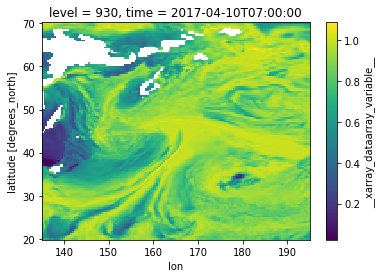

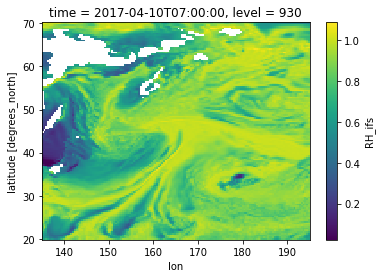

In [33]:
da_rh_depr.__xarray_dataarray_variable__.isel(level=10, time=43).plot()
plt.show()
ds_rhifs_pres.RH_ifs.isel(level=10, time=43).plot()

In [59]:
da_foo=ds_rhifs_pres.RH_ifs.transpose('level','time','lat','lon')
xr.testing.assert_allclose(da_rh_depr.__xarray_dataarray_variable__, da_foo.isel(time=slice(0,72)), rtol=0.35)

---
---
## Old stuff to try out function

Only revisit if something is fishy with the RH_ifs fields

---

In [3]:
### Sequential calculation

def calculate_e_sat(T, phase):
    a1 = 611.21  #Pa
    T0 = 273.16  #K
    # Assign differetn parameter depending on surface of ice or water
    if phase == 'w':
        a3 = 17.502
        a4 = 32.19  #K
    elif phase == 'i':
        a3 = 22.587
        a4 = -0.7 #K
    else:
        raise ValueError("Invalid input: phase must be either 'i' or 'w'")
    ## Calculate the saturation vapor pressure over ice or water
    return a1 * np.exp( a3 * ( (T-T0) / (T-a4) ))

def calculate_e_sat_T(T):
    ## Check that inputtet temperature is in Kelvin
    if T <= 73:          ## It is safe to assume that the temperatue in the troposphere never goes below 73K (-200°C) and would also not exceed 73°C
        raise ValueError("Invalid input: temperature must be in Kelvin")
    # Define threhsold values of temperrture
    T_ice = 250.16
    T_0    = 273.16
    ## Determine alpha:
    if T <= T_ice:
        alpha = 0
    elif T >= T_0:
        alpha=1
    else:
        alpha = ( (T - T_ice) / (T_0 - T_ice) )**2
    ## Calcuzalte the e_sat(T)
    return alpha * calculate_e_sat(T=T, phase='w') + (1-alpha) * calculate_e_sat(T=T, phase='i')
        

def calculate_rh(pres, q, T):
    # Get the Ratio of vapor / dry-air (molar masses)
    epsilon = 0.621981 
    # Calculate the vapor pressure
    vap_pres = pres * q * (1/epsilon) / (1+q * (1/epsilon-1))
    # Calculate the saturation vapor pressure
    e_sat_T = calculate_e_sat_T(T) 
    # Return the ration of vap_pres and sat_vap_pres (=RH)
    return vap_pres / e_sat_T

In [3]:
ds_2dsubset = ds_p.sel(time=slice('20170410-10','20170410-13'), level=slice(750,700), lat=slice(53.2,56), lon=slice(154,158))

In [6]:
# Get the dimensions of the dataset
nlon, nlat = ds_2dsubset.dims['lon'], ds_2dsubset.dims['lat']  
ntime = ds_2dsubset.dims['time']
nlevel = ds_2dsubset.dims['level']

# Initialize an empty NumPy array with the same shape as your dataset
rh_data = np.empty((ntime, nlon, nlat, nlevel))

tstep=0
# Loop through each dimension and apply the calculate_rh function
for t in range(ntime):
    print(f'Done with {tstep} timesteps out of {ntime}')
    tstep +=1
    for x in range(nlon):
        print(f'Calc lon: {x+1} of {nlon}')
        for y in range(nlat):
            for z in range(nlevel):
                pres = ds_2dsubset["level"].isel(level=z).values * 100
                q = ds_2dsubset["Q"].isel(lon=x, lat=y, level=z, time=t).values
                T = ds_2dsubset["T"].isel(lon=x, lat=y, level=z, time=t).values + 273.16
                rh_i = calculate_rh(pres, q, T)
                #rh_data[x, y, z] = rh_i
                
                rh_data[t, x, y, z] = rh_i

Done with 0 timesteps out of 4
Calc lon: 1 of 11
Calc lon: 2 of 11
Calc lon: 3 of 11
Calc lon: 4 of 11
Calc lon: 5 of 11
Calc lon: 6 of 11
Calc lon: 7 of 11
Calc lon: 8 of 11
Calc lon: 9 of 11
Calc lon: 10 of 11
Calc lon: 11 of 11
Done with 1 timesteps out of 4
Calc lon: 1 of 11
Calc lon: 2 of 11
Calc lon: 3 of 11
Calc lon: 4 of 11
Calc lon: 5 of 11
Calc lon: 6 of 11
Calc lon: 7 of 11
Calc lon: 8 of 11
Calc lon: 9 of 11
Calc lon: 10 of 11
Calc lon: 11 of 11
Done with 2 timesteps out of 4
Calc lon: 1 of 11
Calc lon: 2 of 11
Calc lon: 3 of 11
Calc lon: 4 of 11
Calc lon: 5 of 11
Calc lon: 6 of 11
Calc lon: 7 of 11
Calc lon: 8 of 11
Calc lon: 9 of 11
Calc lon: 10 of 11
Calc lon: 11 of 11
Done with 3 timesteps out of 4
Calc lon: 1 of 11
Calc lon: 2 of 11
Calc lon: 3 of 11
Calc lon: 4 of 11
Calc lon: 5 of 11
Calc lon: 6 of 11
Calc lon: 7 of 11
Calc lon: 8 of 11
Calc lon: 9 of 11
Calc lon: 10 of 11
Calc lon: 11 of 11


In [7]:
# Convert the NumPy array back to an xarray DataArray
da_rh = xr.DataArray(
    rh_data,
    coords={
        "time": ds_2dsubset["time"],
        "lon": ds_2dsubset["lon"],
        "lat": ds_2dsubset["lat"],
        "level": ds_2dsubset["level"],
    },
    dims=["time", "lon", "lat", "level"],
)


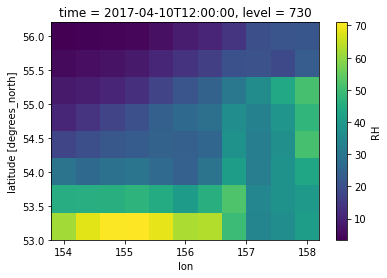

Max Values:
RH_standard:	70.97200012207031
RH_ifs:		84.456


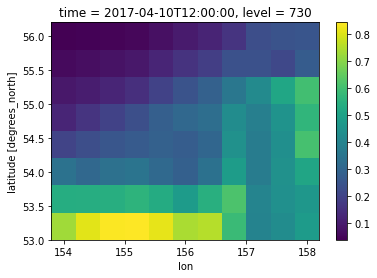

In [11]:
ds_2dsubset.isel(level=2, time=2).RH.plot()
plt.show()
da_rh.isel(level=2, time=2).plot(x='lon')

print(f'Max Values:\nRH_standard:\t{np.round(ds_2dsubset.isel(level=2, time=2).RH.max().values,3)}')
print(f'RH_ifs:\t\t{np.round(da_rh.isel(level=2, time=2).max().values*100,3)}')

In [14]:
da_rh = da_rh.transpose('level','time','lat','lon')

---
---
## Function to calc RH_ifs

In [ ]:

## Calculate RH_i in vectorized form

def calculate_e_sat(T, phase):
    a1 = 611.21  #Pa
    T0 = 273.16  #K
    # Assign differetn parameter depending on surface of ice or water
    if phase == 'w':
        a3 = 17.502
        a4 = 32.19  #K
    elif phase == 'i':
        a3 = 22.587
        a4 = -0.7 #K
    else:
        raise ValueError("Invalid input: phase must be either 'i' or 'w'")
    ## Calculate the saturation vapor pressure over ice or water
    return a1 * np.exp( a3 * ( (T-T0) / (T-a4) ))


def calculate_e_sat_T(T):
    # Define threhsold values of temperrture
    T_ice = 250.16
    T_0    = 273.16


    # Define the conditions
    cond_liq = T >= T_0
    cond_ice = T <= T_ice
    cond_mix = (T > T_ice) & (T < T_0)
    
    # Calculate intermediate alpha values
    alpha_intermediate = ((T - T_ice) / (T_0 - T_ice))**2
    # Define the values for each condition
    values_liq = np.ones_like(T)
    values_ice = np.zeros_like(T)
    values_mix = np.where(cond_mix, alpha_intermediate, 0)

    # Define Alpha by appling conditions and values using np.select
    alpha = np.select([cond_liq, cond_ice, cond_mix], [values_liq, values_ice, values_mix])
    
    e_sat_w = calculate_e_sat(T=T, phase='w') 
    e_sat_i = calculate_e_sat(T=T, phase='i')
    # Calculate e_sat(T) using the previously computed alpha
    return alpha * e_sat_w + (1-alpha) * e_sat_i
        

def calculate_rh(pres, q, T):
    ## Change units
    pres = pres * 100               # Convert hPa to Pa
    T_ndarray = T.values + 273.16   # Convert temperature to Kelvin

    # Get the Ratio of vapor / dry-air (molar masses)
    epsilon = 0.621981 

    # Calculate the vapor pressure
    vap_pres = pres * q * (1/epsilon) / (1 + q * (1/epsilon-1))

    # Calculate the saturation vapor pressure
    e_sat_T = calculate_e_sat_T(T_ndarray) 

    # Convert e_sat_T numpy array to a DataArray with matching dimensions to T
    e_sat_T_da = xr.DataArray(e_sat_T, coords=T.coords, dims=T.dims)

    # Return the ration of vap_pres and sat_vap_pres (=RH)
    return vap_pres / e_sat_T_da

---
---

In [15]:
da_rh_subset = calculate_rh(pres=ds_2dsubset.level, q=ds_2dsubset.Q, T=ds_2dsubset.T)

In [30]:
## Get an estimation of the error (between sequential and parallel calculation)
da_diff = da_rh_subset - da_rh
nr_points = da_rh_subset.lat.shape[0] * da_rh_subset.lon.shape[0] * da_rh_subset.level.shape[0] * da_rh_subset.time.shape[0]

error_median = np.quantile(np.abs(da_diff.values.flatten()), 0.5)
print(f'The median error along all calculated grid-points ({nr_points}) is:\n{error_median:.3e}.')

The median error along all calculated grid-points (2112) is:
1.214e-07.


In [ ]:
## Safe fields
safe_field = False
if safe_field:
    path = '/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields'
    da_rh_fullset.to_netcdf(path=f'{path}/rh_ifs.nc')

In [5]:
da_rh_subset = calculate_rh(pres=ds_p.level, q=ds_p.Q, T=ds_p.T)

In [6]:
da_rh_subset.sel(time='20170410-17').max().values

array(1.34384387)

---
---

### Tests

In [12]:
temperature_array = ds_2dsubset.T + 273.16
T_ice = 250.16
T_0    = 273.16
# Define the conditions
cond1 = temperature_array >= T_0
cond2 = temperature_array <= T_ice
cond3 = (temperature_array > T_ice) & (temperature_array < T_0)

# Define the values for each condition
values_l = np.ones_like(temperature_array)
values_i = np.zeros_like(temperature_array)
values_mix = np.where(cond3, ((temperature_array - T_ice) / (T_0 - T_ice))**2, 0)

# Apply conditions and values using np.select
filtered_array = np.select([cond1, cond2, cond3], [values_l, values_i, values_mix])

print(filtered_array.shape)
#print(filtered_array[0,:,:])


(4, 6, 8, 11)
